## Simple Multiple Pendulums using dynamic symbols
### Introduction


While totally working on homework and not falling down a youtube rabbit hole; I
came across [this video](https://youtu.be/mZ1hF_-cubA?t=163) where they use glow in the dark paint and a light attached to a triple pendulum to show the chaotic and seeminly unpredicable nature of a triple pendlum.
So why not try and tame this chaotic beast.

 The double and triple pendulum is a common classical mechanics problem used to help teach the equations of motions.



![kanes Info](./media/M.png 'how cool')

The mass matrix is augmented by the $𝑘𝑑𝑛ℎ(𝑞,𝑡)$ matrix, and the forcing vector by the $𝑓𝑑𝑛ℎ(𝑞,𝑞˙,𝑢,𝑡)$ vector.

![Triple Pendilum ](./media/my_pen.png 'how cool')


### Kane's Method
##### Why?
- This is a way to calculate equations of motion while not needing to differentiate scalar energy functions for KE and PE. (less computationally expensive)
- Kane's method just requires differentiation of the velocities and acceleration, this can be done by solving vector products. We will let a python library handle that.
-These two factors allow for Kane's method to be a cleaner solution for automated computations

For the automation of these equations, we start with a reference frame centered around the inital pivot point and then attach a point to that frame of length $l$. We assign the forces that will be applied to this mass and then derive the kinesmatic equations for this point. Finally, we make a new reference frame for this point and attach the next mass to it.

### Potential Energy
$n=1 $ <br>
$V = −m_1gy_1$<br>
$V =−m_1gl_1cos\theta_1$


$n=2$ <br>
$V = −m_1gy_1−m_2gy_2$
$V =−m_1gl_1cos\theta_1−m_2g(l_1cos(\theta_1)+l2cos(\theta_2))$

$n=3$ <br>
$V = −m_1gy_1−m_2gy_2−m_3gy_3$
$V =−m_1gl_1cos\theta_1−m_2g(l_1cos(\theta_1)+l2cos(\theta_2))−m_3g(l_1cos(\theta_1)+l2cos(\theta_2)+l3cos(\theta_3))$


$V= \sum_{k=0}^n m_k l_k \sum_{i=0}^k cos(\theta_i)$

### Kinetic Energy
$n=1 $<br>
$T = \frac{1}{2} m_1v_1^2 $<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2 $

$n=2$<br>
$T = \frac{1}{2} m_1v_1^2 +\frac{1}{2} m_2v_2^2$<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2 +\frac{1}{2} m_2(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+2l_1l_2\dot\theta_1
\dot\theta_2cos(\theta_2-\theta_1)    $

$n=3$<br>
$T = \frac{1}{2} m_1v_1^2 +\frac{1}{2} m_2v_2^2+\frac{1}{2} m_3v_3^2$<br>
$T = \frac{1}{2} m_1l_1^2\dot\theta_1^2
+\frac{1}{2} m_2(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+2l_1l_2\dot\theta_1\dot\theta_2cos(\theta_2-\theta_1))+\frac{1}{2} m_3(l_1^2\dot\theta_1^2+l_2^2\dot\theta_2^2+l_3^2\dot\theta_3^2+
2l_1l_2\dot\theta_1\dot\theta_2cos(\theta_2-\theta_1)+
2l_2l_3\dot\theta_2\dot\theta_3cos(\theta_3-\theta_2))    $

You can easily see how once we convert the  kinetic and potential energy into terms of generalized coordinates the kinetic energy equations can easily get out of hand
<br>
$KE = \sum_{k=0}^n \frac{1}{2} m_k \sum_{i,j}^k   l_jl_i\dot\theta_j\dot\theta_icos(\theta_i-\theta_j)) $

In [1]:
from sympy import Dummy, lambdify
from scipy.integrate import odeint
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib import pyplot as plt
from sympy.physics.mechanics import *
import sympy as sy


class n_pendulum:
    def __init__(self, n, times, mass=1, y0=None, position= None,verbose= False):
        """

        :param n: number of masses in the pendulum
        :param times: array of all time points for data to be collected on
        :param mass: weight of each pendulum
        :param y0: inital angle of all pendilums if None
        :param position:
        """
        self.n = n

        self.lengths = np.ones(n) / n  # make all lengths sum to one for clean graphing
        self.masses = [mass] * n

        # dynamic vars
        q = dynamicsymbols(f"q:{n}")  # coordinates
        u = dynamicsymbols(f"u:{n}")  # speeds
        
        
        m = sy.symbols(f"m:{n}")  # Mass
        l = sy.symbols(f"l:{n}")  # Length
        g, t = sy.symbols("g, t")  # Gravity, time

        # Init model
        frame = ReferenceFrame("A")  # referance frame
        point = Point("P")  # pivot point
        point.set_vel(frame, 0)  # set velocity of pivot point

        bodies = []
        loads = []
        kd_eqs = []

        for i in range(n):
            # make new frame
            frame_i = frame.orientnew(f"A{i}", "Axis", [q[i], frame.z])
            frame_i.set_ang_vel(frame, u[i] * frame.z)

            # make new point and have it rotate around previous point
            point_i = point.locatenew(f"P{i}", l[i] * frame_i.x)
            point_i.v2pt_theory(point, frame, frame_i)

            # make new particle at that point
            Pai = Particle(f"Pa{i}", point_i, m[i])
            bodies.append(Pai)

            # Set forces
            loads.append((point_i, m[i] * g * frame.x))
            kd_eqs.append(q[i].diff(t) - u[i])
     
            point = point_i

        # make equations
        method = KanesMethod(frame, q_ind=q, u_ind=u, kd_eqs=kd_eqs)

        # fr generalized  active  forces relative to r
        # fr_star generalized  inertia  forces associated to coordinate r.
        (fr, fr_star) = method.kanes_equations(bodies=bodies, loads=loads)

        kds = method.kindiffdict()
        if verbose:
            print("\n\n\nRHS")
            for t in method.rhs("GE"):
                print(t)
            print()
            for t in kds:
                print(t)
            print("\n\n")
            print(fr)
            print(fr_star)

        if y0 is None:
            if position is None:
                y0 = [4 * np.pi / 8] * n + [0] * n  # inial position and velocities
            else:
                y0 = [position] *n + [0]*n
        parameters = [g] + list(l) + list(m)
        par_val = [1] + list(self.lengths) + list(self.masses) 

        dummy_symbols = [Dummy() for i in q + u]
        dummy_dict = dict(zip(q + u, dummy_symbols))

        # substitute unknown symbols for qdot terms
        mm_sym = method.mass_matrix_full.subs(kds).subs(dummy_dict)
        fo_sym = method.forcing_full.subs(kds).subs(dummy_dict)



        if verbose:
            print(f"y0 {y0}")
            print(f"length {self.lengths}")
            print(f"masses {self.masses}")
            print(f"par {parameters}")
            print(f"par_values {par_val}")
            print("dummy dict", dummy_dict)
            print(f"mass matrix {mm_sym}")
            print(f"force vectors {fo_sym}")


        # create functions for numerical calculation
        mm_func = lambdify(
            dummy_symbols + parameters, mm_sym
        )  #  function taking in symbols and peramitors
        fo_func = lambdify(
            dummy_symbols + parameters, fo_sym
        )  # force function taking in symbols and peramitors

        def f(y, t, args):
            vals = np.concatenate((y, args))  # combine variables
            dydt = np.array(np.linalg.solve(mm_func(*vals), fo_func(*vals))).T[
                0
            ]  # solve mass matrix and force equations

            return dydt

        ##double check rubrick###
        self.init_ode = odeint(f, y0, times, args=(par_val,))

    def get_xy_coords(self):
        """

        :returns: position of all pendilums
        """
        p = self.init_ode
        zeros = np.zeros(self.init_ode.shape[0])[:, None]
        x = np.hstack([zeros, self.lengths * np.sin(p[:, : self.n])])
        y = np.hstack([zeros, -self.lengths * np.cos(p[:, : self.n])])
        return np.cumsum(x, 1), np.cumsum(y, 1)


    def PE(self):
        """
        Calulates Potential energy
        :return:
        """
        pe = np.zeros((len(self.init_ode), self.n))
        thetas = self.init_ode[:, : self.n]

        for k in range(self.n):
            cos_values = 0
            for i in range(k + 1):
                cos_values += np.cos(thetas[:, i])
            cos_values *= self.masses[k] * self.lengths[k]
            pe[:, k] += cos_values

        return -pe



    def KE(self):
        theta_dot = self.init_ode[:, -self.n :]
        theta = self.init_ode[:, : self.n]

        ke_calc = np.zeros((len(self.init_ode), self.n))

        # print(f"KE Formula for n={self.n}")
        for k in range(self.n):
            k_values = 0
            # print(f"k{k} =  1/2 * mass[{k}] * (", end="")
            for i in range(k+1):
                for j in range(i,k+1):
                    if i ==j:
                        # print(f"lengths[{i}]^2 * theta_dot[:, {i}]^2", end=" + ")
                        k_values += np.power(self.lengths[i], 2) * np.power(
                            theta_dot[:, i], 2
                        )
                    else:
                        # print(
                        #     f" 2*lengths[{i}]*lengths[{j}]*theta_dot[:,{i}]*theta_dot[:,{j}]*(np.cos(theta[:,{i}] - theta[:,{j}])"
                        # )
                        k_values += (
                            2
                            * self.lengths[i]
                            * self.lengths[j]
                            * (np.cos(theta[:, i] - theta[:, j]))
                            * theta_dot[:, i]
                            * theta_dot[:, j]
                        )
            k_values *= 0.5 * self.masses[k]
            ke_calc[:, k] += k_values
            # print(")")

        return ke_calc

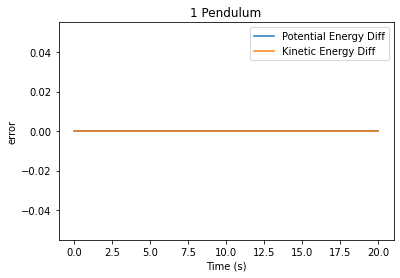

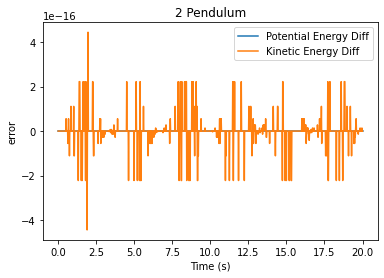

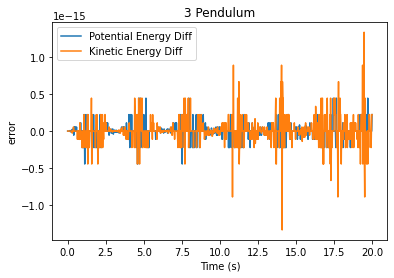

In [26]:
time = np.linspace(0, 20, 1000)
def check_and_plot_energy(n,time):
    app = n_pendulum(n,time,mass=1)
    gpe_values = app.PE()
    ke_values = app.KE()
    theta = app.init_ode[:,:n]
    theta_dot =app.init_ode[:,n:]
    if n == 1:
        V = app.masses[0]*app.lengths[0]*np.cos(theta)
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot,2)
    elif n ==2:
        V = app.masses[0]*app.lengths[0]*np.cos(theta[:,0])\
          +app.masses[1]*(app.lengths[1]*np.cos(theta[:,0])+app.lengths[0]*np.cos(theta[:,1]))
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
        + .5 * app.masses[1]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1]))

#         T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
#             + .5 * app.masses[1]*(+app.lengths[0]*app.lengths[0]*theta_dot[:,0]*theta_dot[:,0]*np.cos(theta[:,0]-theta[:,0])
#                                   +app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1])
#                                   +app.lengths[1]*app.lengths[0]*theta_dot[:,1]*theta_dot[:,0]*np.cos(theta[:,1]-theta[:,0])
#                                   +app.lengths[1]*app.lengths[1]*theta_dot[:,1]*theta_dot[:,1]*np.cos(theta[:,1]-theta[:,1]))

      
    elif n ==3:
        V = app.masses[0]*app.lengths[0]*np.cos(theta[:,0])\
          + app.masses[1]*(app.lengths[0]*np.cos(theta[:,0])+app.lengths[1]*np.cos(theta[:,1]))\
          + app.masses[2]*(app.lengths[0]*np.cos(theta[:,0])+app.lengths[1]*np.cos(theta[:,1])+app.lengths[2]*np.cos(theta[:,2]))
        T = .5 * app.masses[0]*np.power( app.lengths[0],2)*np.power(theta_dot[:,0],2) \
          + .5 * app.masses[1]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1]))\
          + .5 * app.masses[2]*(np.power(app.lengths[0],2)*np.power(theta_dot[:,0],2)
                              +np.power(app.lengths[1],2)*np.power(theta_dot[:,1],2)
                              +np.power(app.lengths[2],2)*np.power(theta_dot[:,2],2)
                              +2*app.lengths[0]*app.lengths[1]*theta_dot[:,0]*theta_dot[:,1]*np.cos(theta[:,0]-theta[:,1])
                              +2*app.lengths[0]*app.lengths[2]*theta_dot[:,0]*theta_dot[:,2]*np.cos(theta[:,0]-theta[:,2])
                              +2*app.lengths[1]*app.lengths[2]*theta_dot[:,1]*theta_dot[:,2]*np.cos(theta[:,1]-theta[:,2]))

    else:
        print("Enter a N value of 1-3")
        return

    if n !=1:
        gpe_values = np.sum(gpe_values,axis=1)
        ke_values=np.sum(ke_values,axis=1)
    pe_difference = np.subtract(gpe_values,-V)

    ke_difference = np.subtract(ke_values,T)
    plt.title(f"{n} Pendulum")
    plt.plot(time,pe_difference,label="Potential Energy Diff")

    plt.plot(time,ke_difference,label="Kinetic Energy Diff")
    plt.xlabel("Time (s)")
    plt.ylabel("error")
    # plt.ylim([-1E-4,1E-4])
    plt.legend()
    plt.show()

check_and_plot_energy(1,time)
check_and_plot_energy(2,time)
check_and_plot_energy(3,time)


### Verification and Analysis

To check that the GPE and KE equations being used are accurate I wrote out the equations by hand for a single, double, and triple pendulum.
Then I plotted the difference between the simulation and the hard coded equations to assess the accuracy of each.
You can see the single pendulum has no errors in it. Once you get to the double pendulum we see some errors in the kinetic energy but these are in the order of 1E-16, so at the point of machine accuracy, nothing more than rounding errors.
The triple pendulum has a slightly larger range for the errors 1E-15, but still near machine percision.


In [5]:
def plot_pen(x_data,y_data,time):

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.axis('off')
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x_data[i], y_data[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(time),
                                   interval=1000 * time[-1] / len(time),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim









def make_plots(n,time):
    app = n_pendulum(n, time, mass=1)
    pe_values = app.PE()
    ke_values = app.KE()
    x_data, y_data = app.get_xy_coords()
    
    total_energy = np.sum(np.add(ke_values, pe_values), axis=1)


    fig, ax = plt.subplots(4,  figsize=(8, 24))
    labels = [f"Point {i+1}" for i in range(n)]

    ax[0].set_title("Energy")
    ax[1].set_title("Y movement over time")
    ax[2].set_title("X movement over time")
    ax[3].set_title(f"{n} Pendulum")
    
    ax[0].plot(time,total_energy,label="Total Energy")
    ax[0].plot(time,np.sum(ke_values,axis=1), label="Kenetic Energy")
    ax[0].plot(time,np.sum(pe_values,axis=1), label= "Potential Energy")
    ax[0].set_ylabel("Energy")
    ax[0].set_xlabel("Time")
    ax[0].legend()
    
    ax[1].plot(time,y_data[:,1:])
    ax[1].set_ylabel("Y Position")
    ax[1].set_xlabel("Time")
    
    ax[1].legend(labels)
    ax[2].plot(time,x_data[:,1:])
    ax[2].set_ylabel("X Position")
    
    ax[2].set_xlabel("Time")
    ax[2].legend(labels)
    
    ax[3].plot(x_data,y_data)
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
    return plot_pen(x_data,y_data,time)
    
    

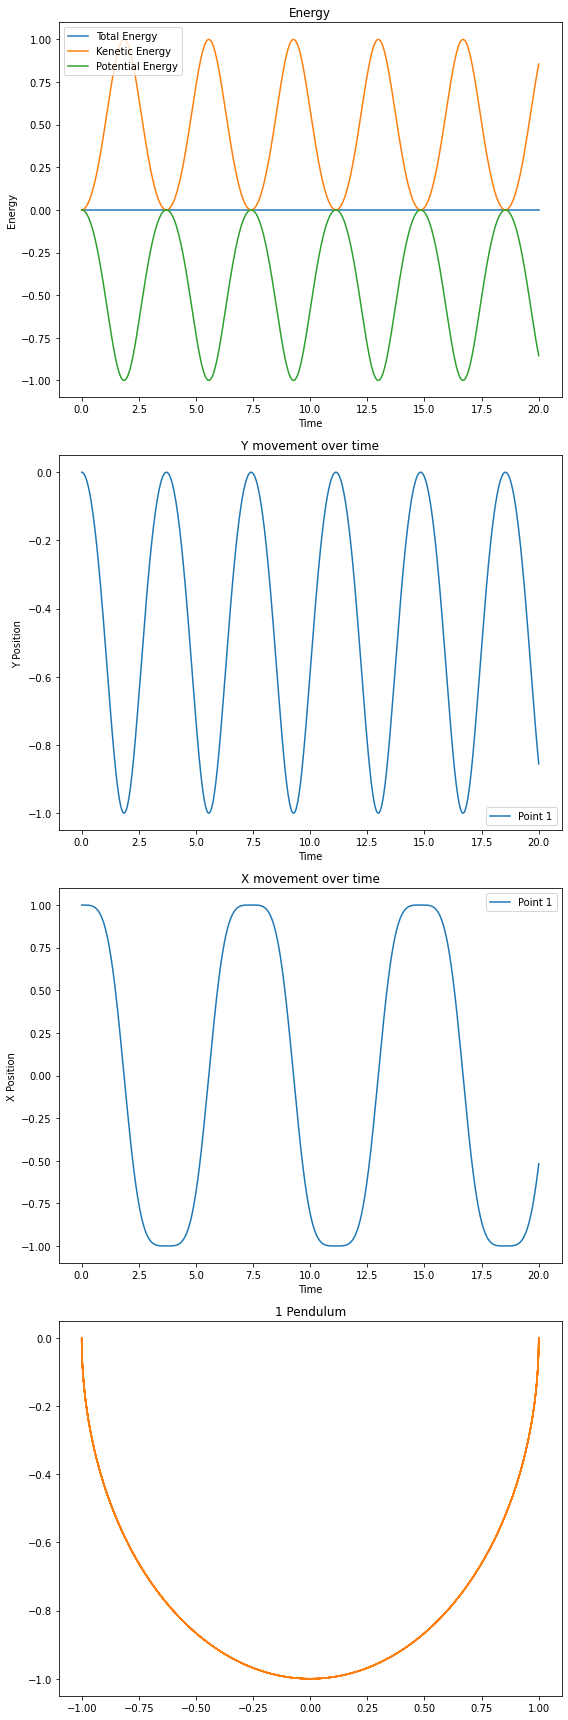

In [7]:
time = np.linspace(0, 20, 1000)

n=1
ani = make_plots(n,time)


In [10]:
HTML(ani.to_html5_video())

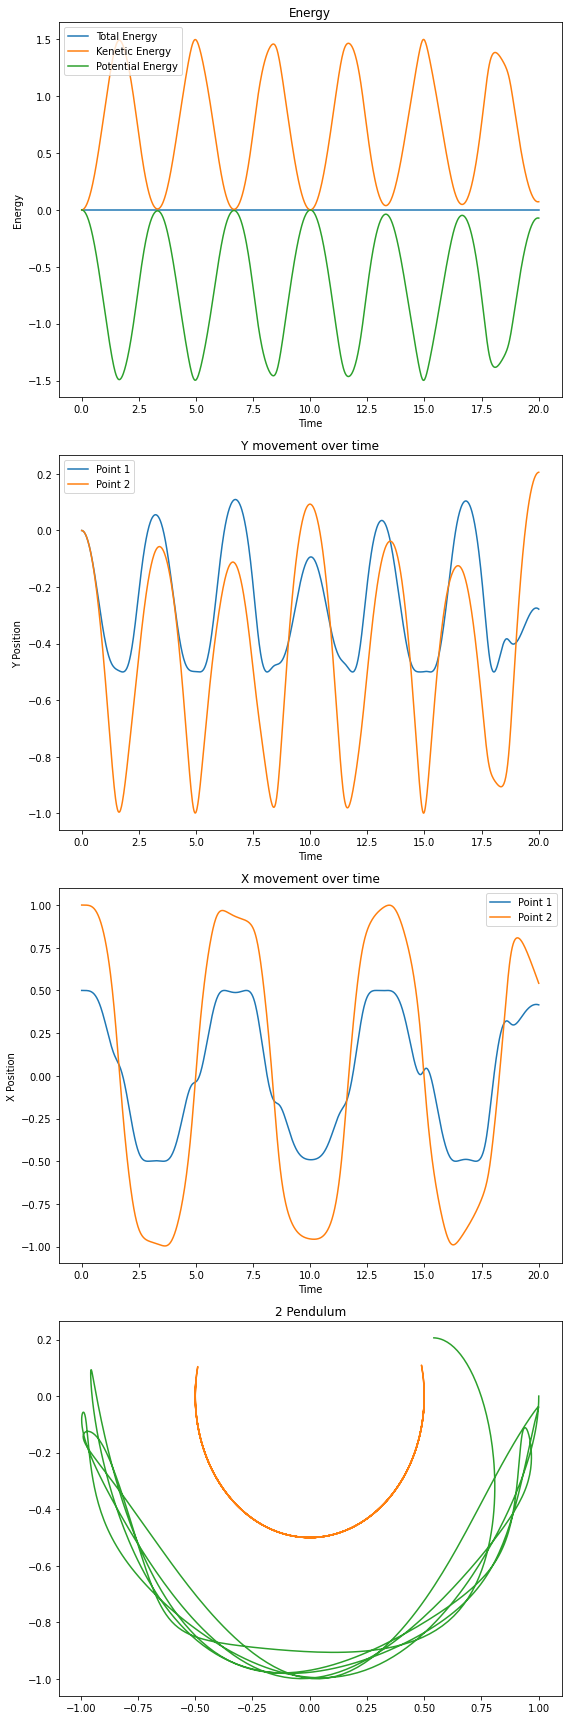

In [11]:
ani = make_plots(2,time)

In [12]:
HTML(ani.to_html5_video())

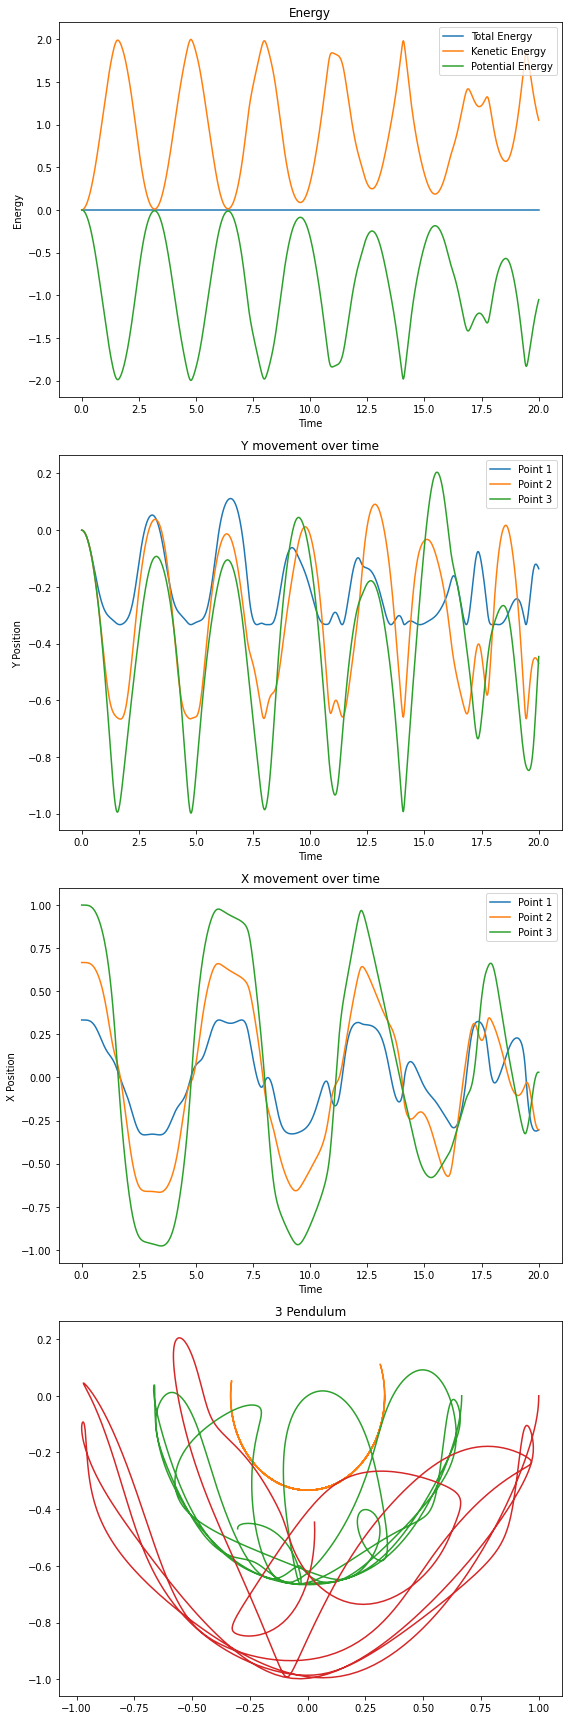

In [13]:
ani = make_plots(3,time)

In [14]:
HTML(ani.to_html5_video())

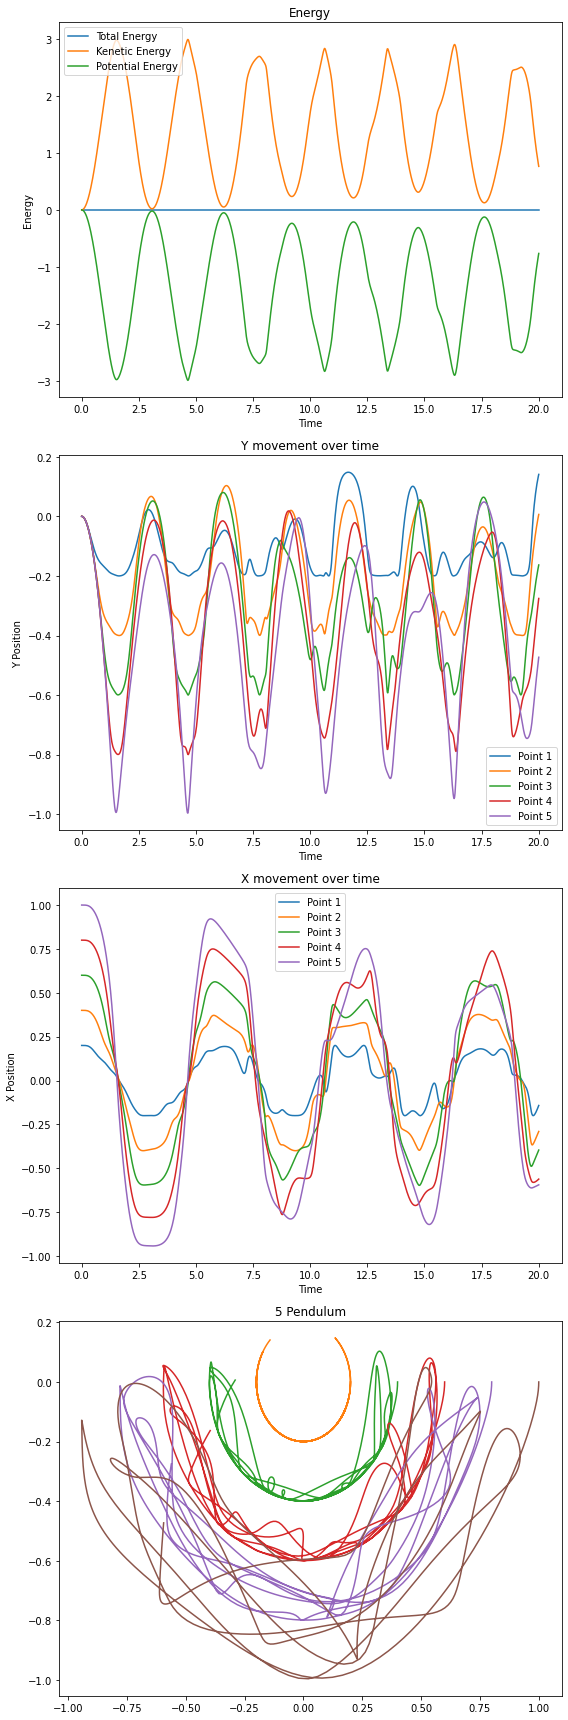

In [15]:
ani = make_plots(5,time)

In [16]:
HTML(ani.to_html5_video())

#### I lost the link to the reference for the code below, it is not mine

In [ ]:
from IPython.display import HTML

from matplotlib import collections



def animate_pendulum_multiple(n, number_of_pendulums=20, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample

    t = np.linspace(0, 20, oversample * 200)
    p = [n_pendulum(n, t, position=3*np.pi/4 + i * perturbation / number_of_pendulums)
         for i in range(number_of_pendulums)]
    positions = np.array([pi.get_xy_coords() for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # positions is a 4D array: (npendulums, len(t), n+1, xy)

    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    track_segments = np.zeros((number_of_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow')
    tracks.set_array(np.linspace(0, 1, number_of_pendulums))
    ax.add_collection(tracks)

    points, = plt.plot([], [], 'ok')

    pendulum_segments = np.zeros((number_of_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((number_of_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.show()
    plt.close(fig)
    return anim


anim = animate_pendulum_multiple(3,number_of_pendulums=50)
# anim.save('media/Crazy_triple.mp4', extra_args=['-vcodec', 'libx264'])
HTML(anim.to_html5_video())

In [23]:
print("1E-3")
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./media/Crazy_triple.mp4"      type="video/mp4">
</video></div>""")

1E-3


In [24]:
print("1E-6")
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./media/Crazy_5.mp4"      type="video/mp4">
</video></div>""")


1E-6


### References
https://docs.sympy.org/latest/modules/physics/mechanics/kane.html <BR>
http://128.84.4.34/pdf/1910.12610<BR>
https://www.researchgate.net/publication/336868500_Equations_of_Motion_Formulation_of_a_Pendulum_Containing_N-point_Masses<BR>
    https://scienceworld.wolfram.com/physics/DoublePendulum.html